# Functions

In [1]:
import requests
import pandas as pd
from time import sleep

def get_top_150_players():
    # 1) Fetch all players & teams
    url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    teams = data['teams']
    team_lookup = {t['id']: t['name'] for t in teams}

    # 2) Build DataFrame of players with now_cost
    players_data = []
    for p in data['elements']:
        players_data.append({
            'id': p['id'],
            'player_name': f"{p['first_name']} {p['second_name']}",
            'team': team_lookup[p['team']],
            'total_points': p['total_points'],
            'points_per_game': float(p['points_per_game']),
            # this season’s cost in £m
            'now_cost': p['now_cost'] / 10  
        })

    df = pd.DataFrame(players_data)
    top_150 = df.sort_values('total_points', ascending=False).head(150).reset_index(drop=True)

    # 3) Helper: fetch ONLY starts from element-summary
    def fetch_starts(pid):
        url = f"https://fantasy.premierleague.com/api/element-summary/{pid}/"
        resp = requests.get(url)
        if resp.status_code != 200:
            print(f"Warning: player {pid} summary error", resp.status_code)
            return None
        hist = resp.json().get('history_past', [])
        for season in hist:
            if season.get('season_name') == "2024/25":
                return season.get('starts', 0)
        return None

    # 4) Fetch starts for each of the top 150
    starts = []
    for pid in top_150['id']:
        starts.append(fetch_starts(pid))
        sleep(0.1)

    top_150['starts'] = starts

    # 5) Compute your metrics
    def safe_div(num, den):
        return None if not den else num/den

    top_150['points_per_start'] = top_150.apply(
        lambda r: safe_div(r['total_points'], r['starts']), axis=1)
    top_150['pts/£'] = top_150.apply(
        lambda r: safe_div(r['total_points'], r['now_cost']), axis=1)

    return top_150

# Example
# df = get_top_150_players()
# print(df[['player_name','team','total_points','starts','points_per_start','now_cost','pts/£']].head())


# Data

In [10]:
player_data_new = get_top_150_players()
player_data_new.head()

,id,player_name,team,total_points,points_per_game,now_cost,starts,points_per_start,pts/£
0,381,Mohamed Salah,Liverpool,344,9.1,14.5,38,9.052632,23.724138
1,119,Bryan Mbeumo,Man Utd,236,6.2,8.0,38,6.210526,29.500000
2,235,Cole Palmer,Chelsea,214,5.8,10.5,36,5.944444,20.380952
3,499,Alexander Isak,Newcastle,211,6.2,10.5,34,6.205882,20.095238
4,525,Chris Wood,Nott'm Forest,200,5.6,7.5,35,5.714286,26.666667


In [12]:
excel_df = pd.read_csv('/Users/torstenwrigley/Downloads/player_data_pappa - player_data_pappa (1).csv')

In [13]:
excel_df.head()

,id,player_name,team,Fix 1-6,Position,start_cost,total_points,new_points,diff_vs_prev_year,points_per_game,...,Fix 1-12,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,381,Mohamed Salah,Liverpool,2,MID,13,344,346,2,9,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,487,Harvey Barnes,Newcastle,2,MID,7,130,128,-2,4,...,1,NaN,Team,GW 1-6,NaN,GW 1-12,NaN,GW 1-3,GW 3-6,GW 7-12
2,452,Amad,Man Utd,1,MID,5,129,133,4,5,...,1,NaN,Arsenal,1,NaN,3,NaN,1,2,3
3,450,Matheus Cunha,Man Utd,1,MID,7,178,190,12,5,...,1,NaN,Aston Villa,3,NaN,3,NaN,3,3,2
4,383,Luis Diaz,Liverpool,2,MID,8,183,185,2,5,...,2,NaN,Brighton,1,NaN,2,NaN,1,3,2


In [17]:
# pick out only the columns you want from df2
to_add = excel_df[['id','Fix 1-6 ', 'new_points', 'diff_vs_prev_year']]

# merge on 'player_id' (left join keeps all rows of df1)
player_data_new = player_data_new.merge(to_add, on='id', how='left')


In [18]:
player_data_new.head()

,id,player_name,team,total_points,points_per_game,now_cost,starts,points_per_start,pts/£,Fix 1-6,new_points,diff_vs_prev_year
0,381,Mohamed Salah,Liverpool,344,9.1,14.5,38,9.052632,23.724138,2.0,346.0,2.0
1,119,Bryan Mbeumo,Man Utd,236,6.2,8.0,38,6.210526,29.500000,1.0,244.0,8.0
2,235,Cole Palmer,Chelsea,214,5.8,10.5,36,5.944444,20.380952,1.0,222.0,8.0
3,499,Alexander Isak,Newcastle,211,6.2,10.5,34,6.205882,20.095238,2.0,209.0,-2.0
4,525,Chris Wood,Nott'm Forest,200,5.6,7.5,35,5.714286,26.666667,1.0,194.0,-6.0


In [20]:
player_data_new.to_csv('player_data_final.csv',index=False)

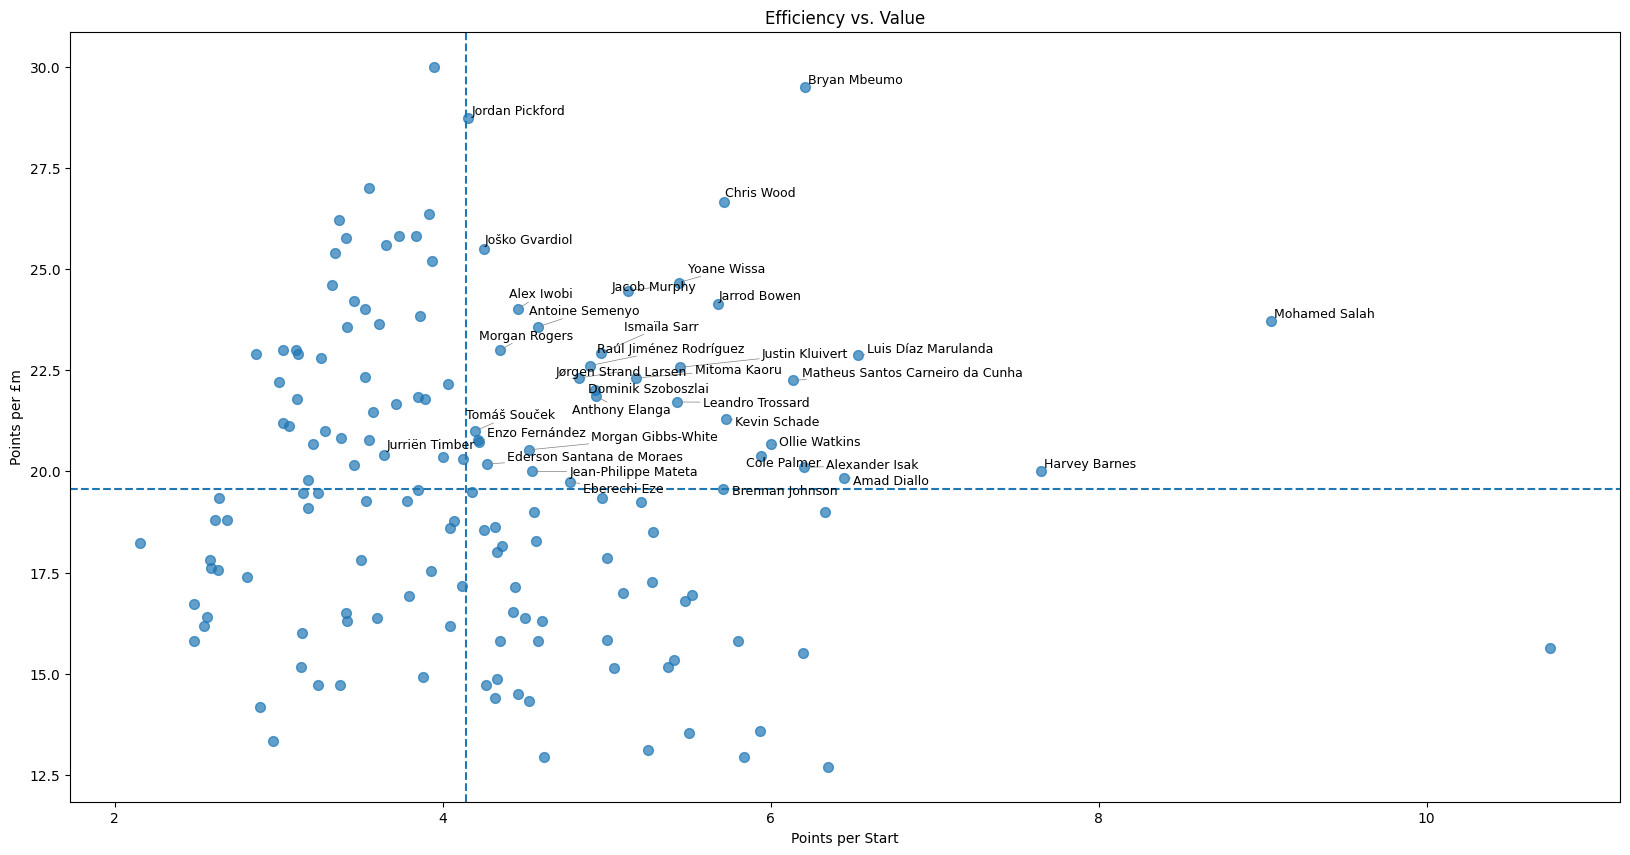

In [21]:
from adjustText import adjust_text
import matplotlib.pyplot as plt

x = player_data_new['points_per_start']
y = player_data_new['pts/£']

plt.figure(figsize=(20, 10))
plt.scatter(x, y, s=50, alpha=0.7)
plt.axvline(x=x.median(), linestyle='--')
plt.axhline(y=y.median(), linestyle='--')
plt.xlabel('Points per Start')
plt.ylabel('Points per £m')
plt.title('Efficiency vs. Value')

# collect text objects
texts = []
for i, row in player_data_new.iterrows():
    if row['points_per_start'] > x.median() and row['pts/£'] > y.median():
        texts.append(
            plt.text(row['points_per_start'],
                     row['pts/£'],
                     row['player_name'],
                     fontsize=9)
        )

# run the automatic adjustment
adjust_text(texts,
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.show()
